Tracked frames: 38
First 5 positions: [(0, 915, 136, 44102.5), (1, 915, 136, 44181.5), (2, 914, 136, 43833.0), (3, 914, 139, 42306.0), (4, 916, 137, 43402.0)]


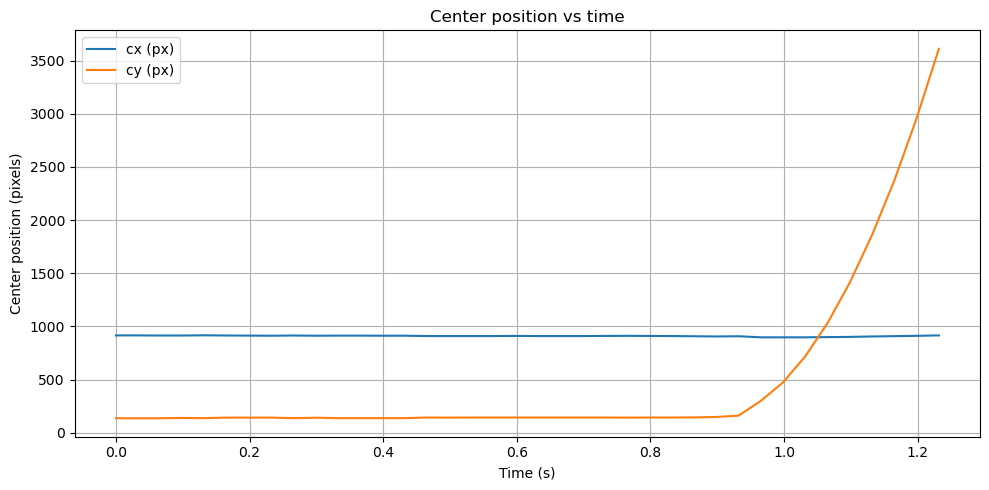

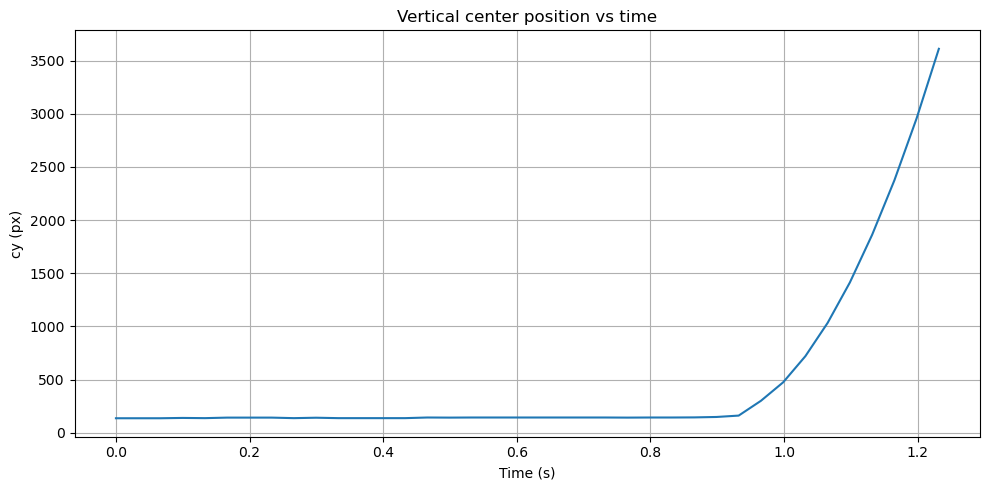

In [ ]:
import cv2
import numpy as np

video_path = "/home/xuwentao/IPT-2026/test-videos/cut-1.mp4"

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {video_path}")

# 读第一帧获取尺寸和fps，用于保存输出视频（可选）
fps = cap.get(cv2.CAP_PROP_FPS) or 30
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 可选：保存一个可视化输出
save_vis = True
out = None
if save_vis:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter("output_annotated.mp4", fourcc, fps, (w, h))

# 阈值参数：越大越“宽松”把暗区域当黑（常见 60~140 之间调）
BLACK_THRESH = 90

# 形态学核：清理噪声/填洞
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

positions = []  # (frame_idx, cx, cy, area)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 灰度
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 可选：轻微模糊，减少噪声
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 黑色主体：灰度低于阈值 -> 1
    _, mask = cv2.threshold(gray_blur, BLACK_THRESH, 255, cv2.THRESH_BINARY_INV)

    # 形态学：先开运算去小噪点，再闭运算填洞
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 选最大轮廓（黑色主体通常面积最大）
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)

        # 面积太小的过滤掉（防噪）
        if area > 200:  # 这个阈值按你视频分辨率调
            x, y, bw, bh = cv2.boundingRect(cnt)

            # 质心
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                positions.append((frame_idx, cx, cy, area))

                # 可视化
                if save_vis:
                    vis = frame.copy()
                    cv2.rectangle(vis, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
                    cv2.circle(vis, (cx, cy), 5, (0, 0, 255), -1)
                    cv2.putText(vis, f"frame={frame_idx}  area={int(area)}",
                                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
                    out.write(vis)

    frame_idx += 1

cap.release()
if out:
    out.release()

print(f"Tracked frames: {len(positions)}")
print("First 5 positions:", positions[:5])



import numpy as np
import matplotlib.pyplot as plt

def plot_center_vs_time_from_positions(positions, fps, show_cx=True, show_cy=True, invert_y=False):
    """
    positions: list of (frame_idx, cx, cy, area)
    fps: float
    invert_y: True 时把 y 轴翻转（图像坐标向下为正 -> 物理直觉向上为正）
    """
    if not positions:
        raise ValueError("positions is empty")

    # 转成 numpy
    frame = np.array([p[0] for p in positions], dtype=float)
    cx    = np.array([p[1] for p in positions], dtype=float)
    cy    = np.array([p[2] for p in positions], dtype=float)

    t = frame / float(fps)

    if invert_y:
        cy = -cy

    # 额外：只画竖直方向更清晰
    plt.figure(figsize=(10, 5))
    plt.plot(t, cy)
    plt.xlabel("Time (s)")
    plt.ylabel("cy (px)" if not invert_y else "-cy (px)")
    plt.title("Vertical center position vs time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ====== 用法：放在你现有代码最后 ======
# 你现有代码里应该已经有 positions 和 fps
plot_center_vs_time_from_positions(positions, fps, invert_y=False)

